In [1]:
# Packages used
using Pkg
Pkg.activate("MLJ_environment", shared=true)
using DataFrames
using Queryverse
using VegaLite
using MLJ

## Objective
To predict what individuals will mostly survive the Titanic disaster and identify the most important factors for survival.

In [2]:
# Show up to 30 columns & 1000 char per line
ENV["COLUMNS"] = 100;
ENV["LINES"] = 1000

# Format Table to Keep left
HTML("""
<style>
table {float:left}
</style>
""")

HTML{String}("<style>\ntable {float:left}\n</style>\n")

## Data 

The titanic dataset describe the survival status of individual passengers on the Titanic. The main source for data about Titanic passengers is the Encyclopedia Titanica and included the research of Eaton & Haas (1994), Patrick Stephens and Michael Findlay. Variable details are given below. 

| Feature  	|                         Description                          	|
|----------	|:------------------------------------------------------------:	|
| Survived 	| Indicates survival (1) or not (0)                            	|
| Pclass   	| Passenger Class (1, 2, 3)                                    	|
| Sex      	| The gender of passenger                                      	|
| Age      	| The age of the passenger                                     	|
| SibSp    	| Number of siblings/spouses aboard                            	|
| Parch    	| Number of parents/children aboard                            	|
| Fare     	| Passenger fare (British pound)                               	|
| Embarked 	| Embarkation (Cherbourg (C); Queenstown (Q); Southampton (S)) 	|



#### Data Preview and Summary

In [3]:
# load data from csv file
titanic = Queryverse.load("/home/chigball/Data/train.csv") |>
@select(-:PassengerId, -:Name, -:Ticket, -:Cabin) |>
@mutate(Survived = string(_.Survived)) |>
DataFrame;

# Preview the data
titanic |> @take(5)

Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
"""0""",3,"""male""",22.0,1,0,7.25,"""S"""
"""1""",1,"""female""",38.0,1,0,71.2833,"""C"""
"""1""",3,"""female""",26.0,0,0,7.925,"""S"""
"""1""",1,"""female""",35.0,1,0,53.1,"""S"""
"""0""",3,"""male""",35.0,0,0,8.05,"""S"""


The target variable here is "Survived".  The other variable help to determine if individuals survived or not.

In [4]:
# Check datatypes and missing values
describe(titanic) |> @select(:variable, :nmissing, :eltype)

variable,nmissing,eltype
:Survived,0,String
:Pclass,0,Int64
:Sex,0,String
:Age,177,"Union{Missing, Float64}"
:SibSp,0,Int64
:Parch,0,Int64
:Fare,0,Float64
:Embarked,0,String


#### Data Summary

* The variable "Embarked" has a couple of missing values in the form of "", so these values will be filtered out  
* The variable age had missing values imputed during modeling

In [5]:
# Filter out "" from Embarked
titanic = titanic |> @filter(_.Embarked != "") |> DataFrame;

#### Data Exploration 
How is survival impacted by different features?  This questions will investigated with a series of bar charts.  

In [6]:
# Data For exploration 
titanic_e = titanic |>
@select(-:PassengerId, -:Name, -:Ticket, -:Cabin) |>
DataFrame;


In [7]:
## Plot for Pclass
p1 =
@vlplot(
  data = titanic_e,
  mark = :bar,
  x = "Pclass:n",
  y = {"mean(Survived)", title = "Survival Rate"},
  height = 200,
  width = 200,
);

## Plot for Sex
p2 =
@vlplot(
  data = titanic_e,
  mark = :bar,
  x = "Sex:n",
  y = {"mean(Survived)", title = "Survival Rate"},
  height = 200,
  width = 200,
);


## Plot for SibSp
p3 =
@vlplot(
  data = titanic_e,
  mark = :bar,
  x = "SibSp:n",
  y = {"mean(Survived)", title = "Survival Rate"},
  height = 200,
  width = 200,
);


## Plot for Embarked
p4 =
@vlplot(
  data = titanic_e,
  mark = :bar,
  x = "Embarked:n",
  y = {"mean(Survived)", title = "Survival Rate"},
  height = 200,
  width = 200,
);


# Plot of Fare
p5 = @vlplot(
  data = titanic_e,
  mark = :bar,
  x = "Survived:n",
  y = {"mean(Fare)", title = "Average Fare"},
  width = 200,
  height = 200
);

# Plot of Age
p6 = @vlplot(
  data = titanic_e,
  mark = :bar,
  x = {"Age:n", bin = true, title = "Age"},
  y = {"mean(Survived)", title = "Survival Rate"},
  height = 200,
  width = 200
);

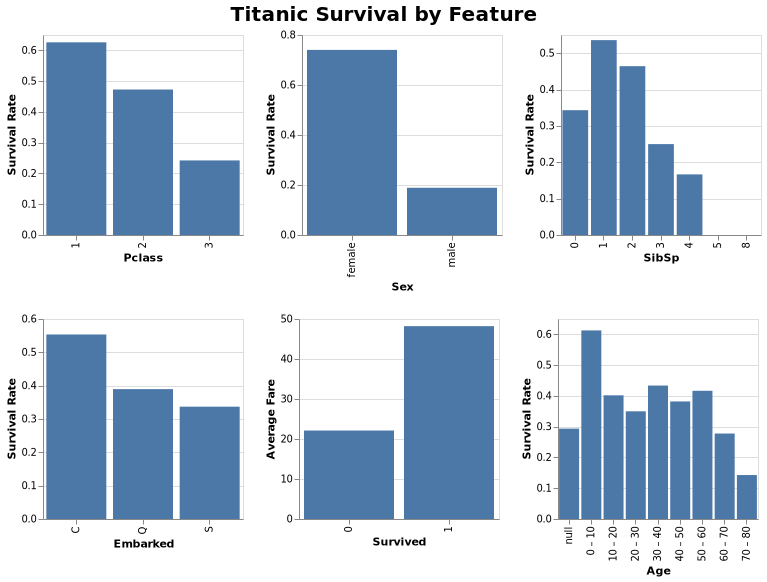

In [8]:
# Plot titanic survival by feature
@vlplot(title={text = "Titanic Survival by Feature", fontSize = 20, anchor = "middle"}) + 
[[p1 p2 p3 ]; [p4 p5 p6]]

#### Obervations 

* Age makes a difference to the survival rate.  Children less than 10 were more likely to have been protected where as the elderly were given less priority. 

* Higher class people had a higher survival rate.

* Females had a higher survival rate than males.

* People with 1 or 2 siblings onboard tend to fare the best compared to people no siblings or > 2 siblings.

* Embarkation from Cherbourg was assoicated with higer survial rate.

## EvoTree Classification Model

EvoTree is Julia's implementation of a boosted trees.  In this case a classification model will be used to predict if individuals survived. 

#### Model Schema

The schema describes how Julia’s machine learning algorithms will understand the data. In the case of EvoTree classification all predictor variables need to be converted to continuous.  

In [9]:
# Schema of the data
schema(titanic) 


┌──────────┬─────────────────────────┬────────────────────────────┐
│ _.names  │ _.types                 │ _.scitypes                 │
├──────────┼─────────────────────────┼────────────────────────────┤
│ Survived │ String                  │ Textual                    │
│ Pclass   │ Int64                   │ Count                      │
│ Sex      │ String                  │ Textual                    │
│ Age      │ Union{Missing, Float64} │ Union{Missing, Continuous} │
│ SibSp    │ Int64                   │ Count                      │
│ Parch    │ Int64                   │ Count                      │
│ Fare     │ Float64                 │ Continuous                 │
│ Embarked │ String                  │ Textual                    │
└──────────┴─────────────────────────┴────────────────────────────┘
_.nrows = 889


#### Model Pipeline

An initial pipeline is built to predict survival.  The pipeline consists of a fill_imputer, onehotencoder and a evo_tree_classifier.

In [10]:
# Filter out missing Sex
titanic = titanic |> @filter(isna(_.Embarked)==false) |> DataFrame

# Choose X
X = titanic |> 
@select(-:Survived) |>  
DataFrame;

# Choose y
y = categorical(titanic.Survived);

# Load model
Tree = @load EvoTreeClassifier pkg="EvoTrees"

# Create a model composite pipeline
pipe = @pipeline(
  X -> coerce!(X,  :Pclass=>Multiclass, :Sex=>Multiclass, :SibSp=>Continuous, :Parch=>Continuous, :Fare=>Continuous,:Embarked=>Multiclass),
  FillImputer(),
  OneHotEncoder(),
  Tree(max_depth = 8),
  prediction_type = :probabilistic
)   

# Fit a machine from the pipeline
mach = machine(pipe, X, y)
fit!(mach);

pipe

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/chigball/.julia/packages/MLJModels/9mQfs/src/loading.jl:168


import EvoTrees ✔


┌ Info: Training Machine{Pipeline275,…} @290.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/nMmot/src/machines.jl:342
┌ Info: Training Machine{FillImputer,…} @231.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/nMmot/src/machines.jl:342
┌ Info: Training Machine{OneHotEncoder,…} @769.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/nMmot/src/machines.jl:342
┌ Info: Spawning 3 sub-features to one-hot encode feature :Pclass.
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/9mQfs/src/builtins/Transformers.jl:1142
┌ Info: Spawning 2 sub-features to one-hot encode feature :Sex.
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/9mQfs/src/builtins/Transformers.jl:1142
┌ Info: Spawning 3 sub-features to one-hot encode feature :Embarked.
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/9mQfs/src/builtins/Transformers.jl:1142
┌ Info: Training Machine{EvoTreeClassifier{Float64,…},…} @599.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/nMmot/src/machines.jl:342


Pipeline275(
    fill_imputer = FillImputer(
            features = Symbol[],
            continuous_fill = MLJModels._median,
            count_fill = MLJModels._round_median,
            finite_fill = MLJModels._mode),
    one_hot_encoder = OneHotEncoder(
            features = Symbol[],
            drop_last = false,
            ordered_factor = true,
            ignore = false),
    evo_tree_classifier = EvoTreeClassifier(
            loss = EvoTrees.Softmax(),
            nrounds = 10,
            λ = 0.0,
            γ = 0.0,
            η = 0.1,
            max_depth = 8,
            min_weight = 1.0,
            rowsample = 1.0,
            colsample = 1.0,
            nbins = 64,
            α = 0.5,
            metric = :mlogloss,
            rng = MersenneTwister(444, (0, 9018, 8016, 994)),
            device = "cpu")) @563

## Model Evaluation 
* A simple resampling strategy at 0.7 was used
* LogLoss and ZeroOneLose were measured

In [11]:
evaluate!(mach, resampling=Holdout(fraction_train=0.7, rng=1234),measure=[LogLoss(), ZeroOneLoss()])

┌───────────────────────────────────┬───────────────┬────────────┐
│ _.measure                         │ _.measurement │ _.per_fold │
├───────────────────────────────────┼───────────────┼────────────┤
│ \eLogLoss{Float64} @691\e │ 0.46          │ [0.46]     │
│ ZeroOneLoss                       │ 0.184         │ [0.184]    │
└───────────────────────────────────┴───────────────┴────────────┘
_.per_observation = [[[0.188, 2.26, ..., 0.0648]], [[0.0, 1.0, ..., 0.0]]]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


#### Learning Curves
These curves allow us to tune the parameters of models.  The parameters nrounds and max_dept are investigated​.

In [12]:
# Define ranges for tuning
r1 = range(pipe, :(evo_tree_classifier.nrounds), lower=2, upper = 300) 
r2 = range(pipe, :(evo_tree_classifier.max_depth), lower=2, upper = 15) 

# Create 2 learning curves
curve1 = learning_curve(mach; range=r1, resampling=Holdout(fraction_train=0.7, rng=1234), measure=LogLoss());
curve2 = learning_curve(mach; range=r2, resampling=Holdout(fraction_train=0.7, rng=1234), measure=LogLoss());


┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…} @164.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/nMmot/src/machines.jl:342
┌ Info: Attempting to evaluate 30 models.
└ @ MLJTuning /home/chigball/.julia/packages/MLJTuning/7mI9k/src/tuned_models.jl:564
Evaluating over 30 metamodels: 100%[=========================] Time: 0:00:10
┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…} @693.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/nMmot/src/machines.jl:342
┌ Info: Attempting to evaluate 14 models.
└ @ MLJTuning /home/chigball/.julia/packages/MLJTuning/7mI9k/src/tuned_models.jl:564
Evaluating over 14 metamodels: 100%[=========================] Time: 0:00:01


In [13]:
# Function to plot learning curves
function plot_lc(curve::NamedTuple, measure::String)
  
  # Create a dataframe from data
  df = DataFrame(parameter_values = curve.parameter_values, measurements = curve.measurements)
  
  # Use vlplot to plot data  
  @vlplot(
    data = df,
    mark = {:line, tooltip = true, point = true},
    x = {"parameter_values:q", title = curve.parameter_name},
    y = {"measurements:q", title = measure},
    height = 250,
    width = 260
  )  

end

plot_lc (generic function with 1 method)

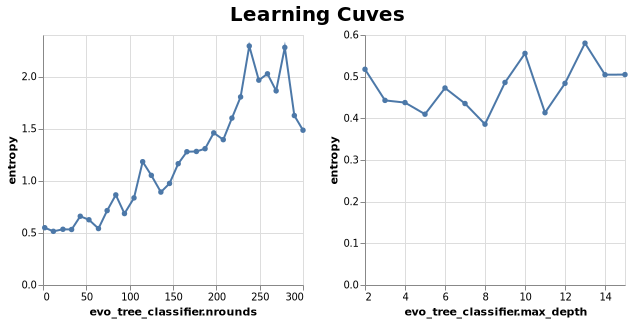

In [14]:
# Plot of the learning curves
p1 = plot_lc(curve1, "entropy");
p2 = plot_lc(curve2, "entropy");

@vlplot(title = {text = "Learning Cuves", fontSize = 20, anchor = "middle"}) + 
[p1 p2]


#### Model Tuning
Based on the learning curves a max_dept = 6 and nrounds = 50 were used to rebuild the model.  

In [15]:
# Tuning paramaters
pipe.evo_tree_classifier.max_depth = 6;
pipe.evo_tree_classifier.nrounds = 50;

# Refit the machine
mach = machine(pipe, X, y)
fit!(mach)

┌ Info: Training Machine{Pipeline275,…} @440.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/nMmot/src/machines.jl:342
┌ Info: Training Machine{FillImputer,…} @946.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/nMmot/src/machines.jl:342
┌ Info: Training Machine{OneHotEncoder,…} @746.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/nMmot/src/machines.jl:342
┌ Info: Spawning 3 sub-features to one-hot encode feature :Pclass.
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/9mQfs/src/builtins/Transformers.jl:1142
┌ Info: Spawning 2 sub-features to one-hot encode feature :Sex.
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/9mQfs/src/builtins/Transformers.jl:1142
┌ Info: Spawning 3 sub-features to one-hot encode feature :Embarked.
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/9mQfs/src/builtins/Transformers.jl:1142
┌ Info: Training Machine{EvoTreeClassifier{Float64,…},…} @393.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/nMmot/src/machines.jl:342


Machine{Pipeline275,…} @440 trained 1 time; caches data
  args: 
    1:	Source @682 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{2}}, AbstractVector{Union{Missing, Continuous}}, AbstractVector{Multiclass{3}}}}`
    2:	Source @358 ⏎ `AbstractVector{Multiclass{2}}`


## Feature Importance
The variable importance plot is consistent with higher class people (who tend to pay a higher fare) and women being more likely to have survived the titanic disaster.  

In [16]:
# A function to extract the feature importance from a mach object of an evotree classifier
function Importance(mach::Machine)
    df = report(mach).evo_tree_classifier |> DataFrame |>
    @mutate(Feature = first.(_.feature_importances)) |>
    @mutate(Importance = last.(_.feature_importances)) |>
    @mutate(Importance = round.(_.Importance, digits = 2)) |>
    @filter(_.Importance > 0) |> 
    @select(:Feature, :Importance) |> 
    @vlplot(
        x = "Importance:q",
        y = {"Feature:n", sort = "-x"},
        mark = {:bar, tooltops = true},
        height = 300,
        title = "Feature Importance Ranking"    
    )
end

Importance (generic function with 1 method)

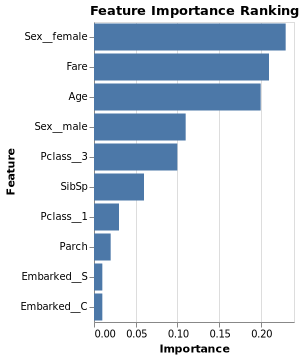

In [17]:
# Plot the feature importance ranking
Importance(mach)

## Conclusion

An EvoTree classifier was used to predict which member were most likely to survive the Titanic disaster. Being a woman, belonging to first class and being a young child were associated with higher survival rates.  